# Reproducibility of replicates

## Imports

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scipy.stats import pearsonr, spearmanr

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [4]:
set_seed(0)

## Load anndata

In [5]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_111.obs["leiden_subclusters"]
]
anndataset_111 = anndataset_111[include_cells]


# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]

batches = anndataset_111.obs["batch_indices"].values.ravel()
ad_d1 = anndataset_111[:, hvg_111][batches==0]
ad_d2 = anndataset_111[:, hvg_111][batches==1]
ad_d2.obs["batch_indices"] -= 1

dataset_111_d1 = AnnDatasetFromAnnData(ad=ad_d1)
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111[batches==0].obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111_d1.initialize_cell_measurement(protein_data_111)
dataset_111_d1.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_111_d2 = AnnDatasetFromAnnData(ad=ad_d2)
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=ad_d2.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111_d2.initialize_cell_measurement(protein_data_111)
dataset_111_d2.gene_names = anndataset_111[:, hvg_111].var_names.values

Trying to set attribute `.obs` of view, making a copy.


[2020-04-03 15:17:03,521] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-03 15:17:03,523] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-03 15:17:03,815] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:17:04,131] INFO - scvi.dataset.dataset | Downsampled from 8736 to 8736 cells
[2020-04-03 15:17:06,525] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-03 15:17:06,528] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-03 15:17:06,764] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:17:06,948] INFO - scvi.dataset.dataset | Downsampled from 6868 to 6868 cells


## Load models

In [6]:
model_d1 = TOTALVI(
    dataset_111_d1.nb_genes,
    dataset_111_d1.protein_expression.shape[1],
    n_latent=20,
)
model_d2 = TOTALVI(
    dataset_111_d2.nb_genes,
    dataset_111_d2.protein_expression.shape[1],
    n_latent=20,
)

In [7]:
model_d1.load_state_dict(torch.load("saved_models/111_d1.pt"))
model_d1.eval()

model_d2.load_state_dict(torch.load("saved_models/111_d2.pt"))
model_d2.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4115, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [8]:
use_cuda = True
trainer_d1 = TotalTrainer(
    model_d1,
    dataset_111_d1,
    use_cuda=use_cuda,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

trainer_d2 = TotalTrainer(
    model_d2,
    dataset_111_d2,
    use_cuda=use_cuda,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Create posteriors

In [10]:
# create posterior on full data
full_posterior_d1 = trainer_d1.create_posterior(
    model_d1, dataset_111_d1, indices=np.arange(len(dataset_111_d1)), type_class=TotalPosterior
)
full_posterior_d2 = trainer_d2.create_posterior(
    model_d2, dataset_111_d2, indices=np.arange(len(dataset_111_d2)), type_class=TotalPosterior
)

## Run one vs all DE

In [11]:
# Call scvi function
per_cluster_de_d1_list, cluster_id_d1 = full_posterior_d1.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)
per_cluster_de_d1 = {}
for i, c in enumerate(cluster_id_d1):
    per_cluster_de_d1[c] = per_cluster_de_d1_list[i]

# Call scvi function
per_cluster_de_d2_list, cluster_id_d2 = full_posterior_d2.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)
per_cluster_de_d2 = {}
for i, c in enumerate(cluster_id_d2):
    per_cluster_de_d2[c] = per_cluster_de_d2_list[i]

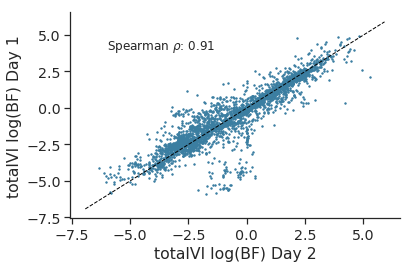

In [12]:
fig, ax = plt.subplots(1, 1)

xs, ys = [], []
for c in per_cluster_de_d1.keys():

    pro_rows = per_cluster_de_d1[c].index.str.contains('ADT_')
    total_temp = per_cluster_de_d1[c].iloc[pro_rows]

    pro_rows = per_cluster_de_d2[c].index.str.contains('ADT_')
    bg_temp = per_cluster_de_d2[c].iloc[pro_rows]

    df = pd.DataFrame(index = bg_temp.index)
    df["totalVI log(BF) Day 2"] = bg_temp["bayes_factor"].values
    total_temp = total_temp.loc[df.index]
    df["totalVI log(BF) Day 1"] = total_temp["bayes_factor"]

    xs.append(df["totalVI log(BF) Day 2"].values.ravel())
    ys.append(df["totalVI log(BF) Day 1"].values.ravel())

    df.plot.scatter("totalVI log(BF) Day 2", "totalVI log(BF) Day 1", ax=ax, c=colors[0], s=2)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)

xs = np.concatenate(xs)
ys = np.concatenate(ys)
rho = np.round(spearmanr(xs, ys)[0], 2)
ax.text(-6, 4, r"Spearman $\rho$: {}".format(rho), fontsize=12)
sns.despine()
plt.tight_layout()
fig.savefig("figures/day1_day_2.pdf")

0.9535649076933481


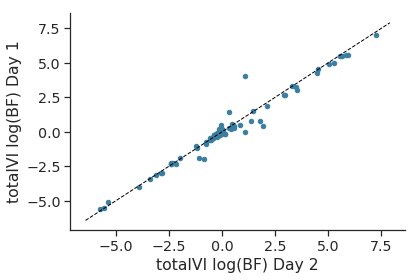

In [13]:
c = "Mature B"
pro_rows = per_cluster_de_d1[c].index.str.contains('ADT_')
total_temp = per_cluster_de_d1[c].iloc[pro_rows]

pro_rows = per_cluster_de_d2[c].index.str.contains('ADT_')
bg_temp = per_cluster_de_d2[c].iloc[pro_rows]

df = pd.DataFrame(index = bg_temp.index)
df["totalVI log(BF) Day 2"] = bg_temp["mean"].values
total_temp = total_temp.loc[df.index]
df["totalVI log(BF) Day 1"] = total_temp["mean"]

fig, ax = plt.subplots(1, 1)

df.plot.scatter("totalVI log(BF) Day 2", "totalVI log(BF) Day 1", ax=ax, c=colors[0])

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)
print(spearmanr(df["totalVI log(BF) Day 2"], df["totalVI log(BF) Day 1"])[0])
sns.despine()

## Scanpy DE

In [14]:
pro_adata_d1 = anndata.AnnData(np.log1p(dataset_111_d1.protein_expression))
pro_adata_d1.var.index = dataset_111_d1.protein_names
pro_adata_d1.raw = pro_adata_d1
pro_adata_d1.obs["cell_types"] = pd.Categorical([dataset_111_d1.cell_types[l] for l in dataset_111_d1.labels.ravel()])
pro_adata_d1.var["protein_names"] = [s.split("_")[1] for s in dataset_111_d1.protein_names]

pro_adata_d2 = anndata.AnnData(np.log1p(dataset_111_d2.protein_expression))
pro_adata_d2.var.index = dataset_111_d2.protein_names
pro_adata_d2.raw = pro_adata_d2
pro_adata_d2.obs["cell_types"] = pd.Categorical([dataset_111_d2.cell_types[l] for l in dataset_111_d2.labels.ravel()])
pro_adata_d2.var["protein_names"] = [s.split("_")[1] for s in dataset_111_d2.protein_names]

In [15]:
for ad in [pro_adata_d1, pro_adata_d2]:
    sc.tl.rank_genes_groups(
        ad,
        "cell_types",
        use_raw=True,
        method="wilcoxon",
        n_genes=ad.X.shape[1],
        key_added="rank_genes_groups_wilcox",
    )
    sc.tl.rank_genes_groups(
        ad,
        "cell_types",
        use_raw=True,
        method="t-test",
        n_genes=ad.X.shape[1],
        key_added="rank_genes_groups_ttest",
    )
    sc.tl.rank_genes_groups(
        ad,
        "cell_types",
        use_raw=True,
        method="t-test_overestim_var",
        n_genes=ad.X.shape[1],
        key_added="rank_genes_groups_ttest_ov",
    )

In [16]:
# sum(sc.get.rank_genes_groups_df(pro_adata_d2, "Mature B", key="rank_genes_groups_ttest")["pvals_adj"].values < 0.05)

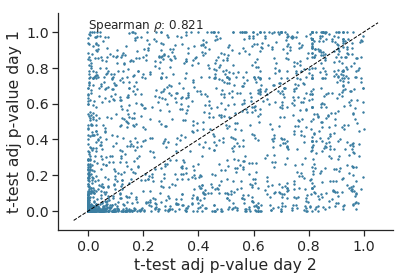

In [17]:
d1 = sc.get.rank_genes_groups_df(pro_adata_d1, "Mature B", key="rank_genes_groups_ttest").sort_values("names")
d2 = sc.get.rank_genes_groups_df(pro_adata_d2, "Mature B", key="rank_genes_groups_ttest").sort_values("names")

fig, ax = plt.subplots(1, 1)
xs, ys = [], []
for c in per_cluster_de_d1.keys():
    d1 = sc.get.rank_genes_groups_df(pro_adata_d1, c, key="rank_genes_groups_ttest").sort_values("names")
    d2 = sc.get.rank_genes_groups_df(pro_adata_d2, c, key="rank_genes_groups_ttest").sort_values("names")
    
    xs.append(d2["pvals_adj"].values)
    ys.append(d1["pvals_adj"].values)
    
xs = np.concatenate(xs)
ys = np.concatenate(ys)
ax.scatter(xs, ys, s=2)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)
ax.set_ylabel("t-test adj p-value day 1")
ax.set_xlabel("t-test adj p-value day 2")
# ax.set_xscale("log")
# ax.set_yscale("log")
rho = spearmanr(xs, ys)[0]
ax.text(0, 1.02, r"Spearman $\rho$: {}".format(np.round(rho, 3)), fontsize=12)
sns.despine()

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


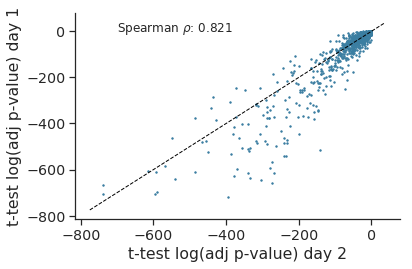

In [18]:
d1 = sc.get.rank_genes_groups_df(pro_adata_d1, "Mature B", key="rank_genes_groups_ttest").sort_values("names")
d2 = sc.get.rank_genes_groups_df(pro_adata_d2, "Mature B", key="rank_genes_groups_ttest").sort_values("names")

fig, ax = plt.subplots(1, 1)
xs, ys, log_xs, log_ys = [], [], [], []
for c in per_cluster_de_d1.keys():

    d1 = sc.get.rank_genes_groups_df(pro_adata_d1, c, key="rank_genes_groups_ttest").sort_values("names")
    d2 = sc.get.rank_genes_groups_df(pro_adata_d2, c, key="rank_genes_groups_ttest").sort_values("names")

    log_xs.append(np.log(d2["pvals_adj"].values))
    log_ys.append(np.log(d1["pvals_adj"].values))
    xs.append(d2["pvals_adj"].values)
    ys.append(d1["pvals_adj"].values)
    
xs = np.concatenate(xs)
ys = np.concatenate(ys)
log_xs = np.concatenate(log_xs)
log_ys = np.concatenate(log_ys)

ax.scatter(log_xs, log_ys, s=2)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)
ax.set_ylabel("t-test log(adj p-value) day 1")
ax.set_xlabel("t-test log(adj p-value) day 2")

rho = spearmanr(xs, ys)[0]
ax.text(-700, 1.02, r"Spearman $\rho$: {}".format(np.round(rho, 3)), fontsize=12)
sns.despine()
plt.tight_layout()

fig.savefig("figures/day1_day_2_t-test.pdf")

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/ipykernel-5.1.2-py3.7.egg/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


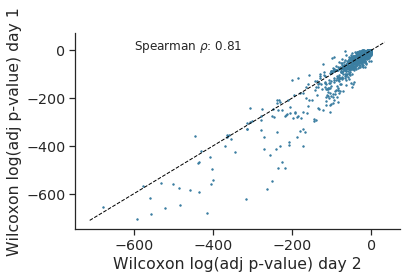

In [19]:
d1 = sc.get.rank_genes_groups_df(pro_adata_d1, "Mature B", key="rank_genes_groups_wilcox").sort_values("names")
d2 = sc.get.rank_genes_groups_df(pro_adata_d2, "Mature B", key="rank_genes_groups_wilcox").sort_values("names")

fig, ax = plt.subplots(1, 1)
xs, ys = [], []
for c in per_cluster_de_d1.keys():
    d1 = sc.get.rank_genes_groups_df(pro_adata_d1, c, key="rank_genes_groups_wilcox").sort_values("names")
    d2 = sc.get.rank_genes_groups_df(pro_adata_d2, c, key="rank_genes_groups_wilcox").sort_values("names")
    
    xs.append(np.log(d2["pvals_adj"].values))
    ys.append(np.log(d1["pvals_adj"].values))
    
xs = np.concatenate(xs)
ys = np.concatenate(ys)
ax.scatter(xs, ys, s=2)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)
ax.set_ylabel("Wilcoxon log(adj p-value) day 1")
ax.set_xlabel("Wilcoxon log(adj p-value) day 2")
# ax.set_xscale("log")
# ax.set_yscale("log")
rho = spearmanr(xs, ys)[0]
ax.text(-600, 1.02, r"Spearman $\rho$: {}".format(np.round(rho, 3)), fontsize=12)
sns.despine()
plt.tight_layout()

fig.savefig("figures/day1_day_2_wilcox.pdf")

## Compare BF to scVI

In [20]:
anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

dataset = AnnDatasetFromAnnData(ad = anndataset)
protein_data = CellMeasurement(name="protein_expression", data=anndataset.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=anndataset.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data)

[2020-04-03 15:25:58,340] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-03 15:25:58,344] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-03 15:25:59,736] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:26:03,162] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [21]:
dataset.update_genes(dataset.var["hvg_encode"])

[2020-04-03 15:26:03,590] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4005 genes
[2020-04-03 15:26:04,827] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:26:05,641] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-03 15:26:06,335] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:26:06,712] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [22]:
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

scvi_vae = VAE(dataset.nb_genes, reconstruction_loss="nb", n_latent=20)
scvi_trainer = UnsupervisedTrainer(
    scvi_vae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=10
)

In [23]:
scvi_trainer.train(lr=2e-3, n_epochs=400)

In [24]:
# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset.obs["leiden_subclusters"]
]
adata2 = anndataset[include_cells].copy()
dataset = AnnDatasetFromAnnData(ad = adata2)
protein_data = CellMeasurement(name="protein_expression", data=adata2.obsm["protein_expression"].astype(np.float32), 
                               columns_attr_name="protein_names", columns=adata2.uns["protein_names"])
dataset.initialize_cell_measurement(protein_data)
dataset.update_genes(dataset.var["hvg_encode"])

[2020-04-03 15:32:40,126] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-03 15:32:40,131] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-03 15:32:41,423] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:32:45,467] INFO - scvi.dataset.dataset | Downsampled from 8736 to 8736 cells
[2020-04-03 15:32:45,497] INFO - scvi.dataset.dataset | Downsampling from 13553 to 4005 genes
[2020-04-03 15:32:46,518] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:32:47,148] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-03 15:32:47,570] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-03 15:32:47,759] INFO - scvi.dataset.dataset | Downsampled from 8736 to 8736 cells


In [25]:
dataset.gene_names = anndataset_111[:, hvg_111].var_names.values

In [26]:
full_scvi_posterior = scvi_trainer.create_posterior(
    scvi_vae, dataset, indices=np.arange(len(dataset)),
)
# full_scvi_posterior = full_scvi_posterior.update({"batch_size":64})
# Call scvi function
per_cluster_de_scvi, cluster_id_scvi = full_scvi_posterior.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)

In [27]:
assert np.array_equal(cluster_id_d1, cluster_id_scvi)

In [28]:
all_comps = []
for c in range(len(per_cluster_de_d1_list)):
    gene_rows = ~per_cluster_de_d1_list[c].index.str.contains('ADT_')
    df1 = per_cluster_de_d1_list[c].loc[gene_rows]["bayes_factor"]
    df2 = per_cluster_de_scvi[c]["bayes_factor"].copy()
    df2 = df2.loc[df1.index]
    joint = pd.concat([df1, df2], axis=1)
    all_comps.append(joint.values)
all_comps = np.concatenate(all_comps)

In [29]:
from scipy.stats import spearmanr

print(spearmanr(all_comps[:, 0], all_comps[:, 1]))

SpearmanrResult(correlation=0.9019453936197523, pvalue=0.0)
(0.751094752172696, 0.0)


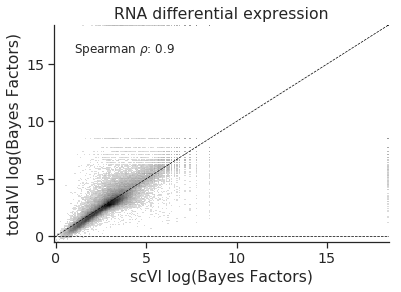

In [30]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots()
# ax.scatter(all_comps[:, 1], all_comps[:, 0], s=1)
ax.hist2d(
    all_comps[:, 1].ravel(),
    all_comps[:, 0].ravel(),
    bins=256,
    norm=mcolors.PowerNorm(0.3),
    cmap=plt.cm.gray_r,
    rasterized=True,
)
ax.axhline(0, c="black", linestyle="--", linewidth=0.7)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", linewidth=0.7)
ax.set_xlabel("scVI log(Bayes Factors)")
ax.set_ylabel("totalVI log(Bayes Factors)")
sp = np.round(spearmanr(all_comps[:, 0], all_comps[:, 1])[0], 2)
ax.annotate(r"Spearman $\rho$: {}".format(sp), (1, 16), fontsize=12)
sns.despine()
ax.set_title("RNA differential expression")
fig.savefig("figures/RNA_totalVI_vs_scVI.pdf", bbox_inches="tight")